In [1]:
'''
Welcome to a small Programming Task for the Birds Eye View Perception Master Thesis Position. Please find the workflow and task instructions below

1) First we load the NuScenes dataset (v1.0-mini). Please update the DATASET_DIR based on your needs or use the default value.

2) We only select the first sample using 'nusc.sample[0]' with 6x camera views in the NuScenes.

3) We load the camera projection and intrinsic matrices and save under the dictionary 'camera_matrices'.

4) We uniformly sample 100 random 3D points with depth range of [5,50], which we also visualize to see.

5) Now, your task is to implement classical 3D-2D projection function which will project the 3D points generated in step 4 to all of the 6 camera views. The CORRECT projection output is also present at the Cell # 8 output. Your points in projected_points_all_cameras should also be exactly same.

6) There is also a BONUS TASK at the end, where you should generate a birds eye view using the projected_points_all_cameras. You are free to choose the colors and BEV_resolution whichever fits the best. 
    I highly reccomend you to solve the BONUS TASK.

'''

"\nWelcome to a small Programming Task for the Birds Eye View Perception Master Thesis Position. Please find the workflow and task instructions below\n\n1) First we load the NuScenes dataset (v1.0-mini). Please update the DATASET_DIR based on your needs or use the default value.\n\n2) We only select the first sample using 'nusc.sample[0]' with 6x camera views in the NuScenes.\n\n3) We load the camera projection and intrinsic matrices and save under the dictionary 'camera_matrices'.\n\n4) We uniformly sample 100 random 3D points with depth range of [5,50], which we also visualize to see.\n\n5) Now, your task is to implement classical 3D-2D projection function which will project the 3D points generated in step 4 to all of the 6 camera views. The CORRECT projection output is also present at the Cell # 8 output. Your points in projected_points_all_cameras should also be exactly same.\n\n6) There is also a BONUS TASK at the end, where you should generate a birds eye view using the projected

In [2]:
######## WARNING: DONOT CHANGE THE CODE (except maybe DATASET_DIR) #######

from nuscenes.nuscenes import NuScenes
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
# Camera channels in NuScenes
camera_channels = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                    'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_BACK_RIGHT']

# Specify the dataset path
DATASET_DIR = "v1.0-mini"  # Update with your dataset directory
nusc = NuScenes(version='v1.0-mini', dataroot=DATASET_DIR, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.776 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


Sample Token: ca9a282c9e77460f8360f564131a8af5
Sample Cameras: dict_keys(['RADAR_FRONT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 'RADAR_BACK_LEFT', 'RADAR_BACK_RIGHT', 'LIDAR_TOP', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_RIGHT', 'CAM_BACK', 'CAM_BACK_LEFT', 'CAM_FRONT_LEFT'])


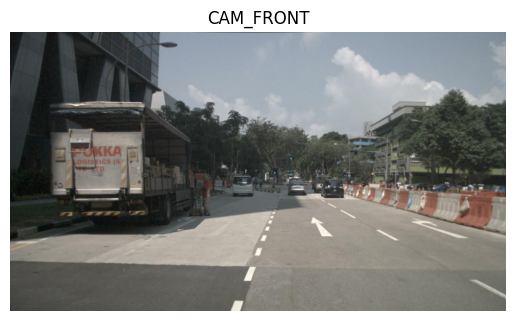

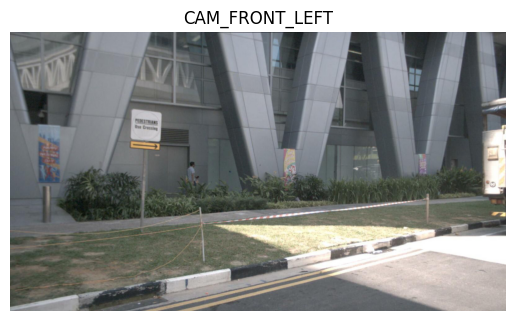

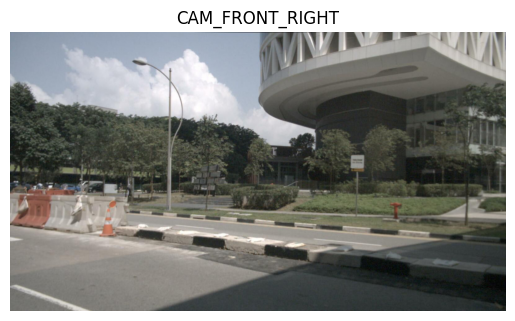

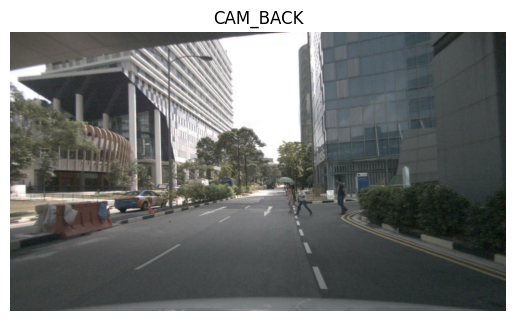

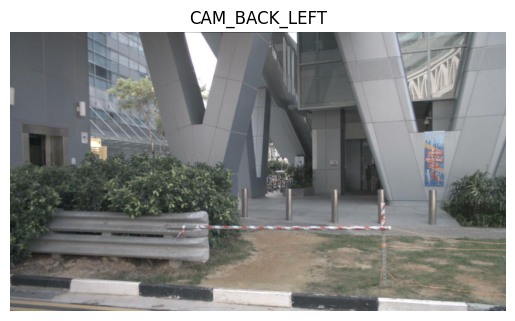

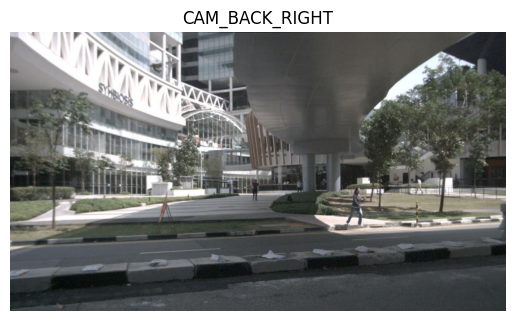

{'CAM_FRONT': 'v1.0-mini/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg', 'CAM_FRONT_LEFT': 'v1.0-mini/samples/CAM_FRONT_LEFT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_LEFT__1532402927604844.jpg', 'CAM_FRONT_RIGHT': 'v1.0-mini/samples/CAM_FRONT_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_FRONT_RIGHT__1532402927620339.jpg', 'CAM_BACK': 'v1.0-mini/samples/CAM_BACK/n015-2018-07-24-11-22-45+0800__CAM_BACK__1532402927637525.jpg', 'CAM_BACK_LEFT': 'v1.0-mini/samples/CAM_BACK_LEFT/n015-2018-07-24-11-22-45+0800__CAM_BACK_LEFT__1532402927647423.jpg', 'CAM_BACK_RIGHT': 'v1.0-mini/samples/CAM_BACK_RIGHT/n015-2018-07-24-11-22-45+0800__CAM_BACK_RIGHT__1532402927627893.jpg'}


In [3]:
######## WARNING: DONOT CHANGE THE CODE  #######

sample = nusc.sample[0]

# Print out the sample data
print("Sample Token:", sample['token'])
print("Sample Cameras:", sample['data'].keys())  # Should include all 6 cameras

img_paths = {}
# Loop through each camera
for channel in camera_channels:

    cam_data_token = sample['data'][channel]
    cam_data = nusc.get('sample_data', cam_data_token)
    img_path = f"{DATASET_DIR}/{cam_data['filename']}"  
    img_paths[channel] = img_path  
    

    img = Image.open(img_path)
    plt.figure()
    plt.title(channel)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


print(img_paths)

In [4]:

######## WARNING: DONOT CHANGE THE CODE  #######

# Dictionary to store calibration data for each camera
camera_matrices = {}

for channel in camera_channels:
    # Get the camera data token
    cam_data_token = sample['data'][channel]
    cam_data = nusc.get('sample_data', cam_data_token)

    # Get the calibration data
    calib_token = cam_data['calibrated_sensor_token']
    calib = nusc.get('calibrated_sensor', calib_token)

    # Intrinsic and extrinsic parameters
    camera_intrinsic = np.array(calib['camera_intrinsic'])  # Intrinsic matrix
    camera_translation = np.array(calib['translation'])     # Translation vector
    camera_rotation = Quaternion(calib['rotation']).rotation_matrix  # Rotation matrix

    # Save matrices in the dictionary
    camera_matrices[channel] = {
        'intrinsic': camera_intrinsic,
        'translation': camera_translation,
        'rotation': camera_rotation
    }

    print(f"Channel: {channel} saved.")

Channel: CAM_FRONT saved.
Channel: CAM_FRONT_LEFT saved.
Channel: CAM_FRONT_RIGHT saved.
Channel: CAM_BACK saved.
Channel: CAM_BACK_LEFT saved.
Channel: CAM_BACK_RIGHT saved.


In [5]:
######## WARNING: DONOT CHANGE THE CODE  #######

# Set a seed for reproducibility
np.random.seed(42) 

num_points = 1000 
depth_range = [5, 50]  
points_3d_camera = np.random.uniform(low=depth_range[0], high=depth_range[1], size=(num_points, 3))

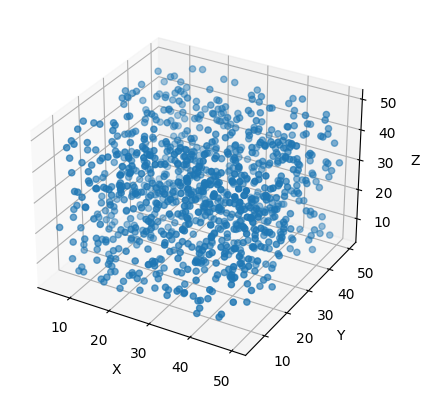

In [6]:
######## WARNING: DONOT CHANGE THE CODE  #######

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(points_3d_camera[:, 0], points_3d_camera[:, 1], points_3d_camera[:, 2])

# Label the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [7]:
######## TODO: PLEASE ADD YOUR CODE HERE  #######

#Small_hint: Dont forget to filter valid_points inside the image.

# Create a dictionary to store 2D projections for each camera, it should have the related 2D points for the respective camera e.g. projected_points_all_cameras = {"CAM_FRONT":list of 2d points,..., and so on, for all 6 camera views}
projected_points_all_cameras = {}

def project_3d_2d(points_3d, intrinsic, extrinsic, image_width, image_height):
    #print(points_3d.shape)
    #print(intrinsic.shape)
    #print(extrinsic.shape)
    #print(extrinsic)
    
    # For transforming 3D points to camera coordinate system we have to
    # Add a column of ones to points_3d to get homogeneous coordinates
    points_3d_homogeneous = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    #print(points_3d_homogeneous.shape)
    
    # Now transform 3D points to camera coordinate system
    cam_points_3d = np.dot(extrinsic, points_3d_homogeneous.T)
    #print(cam_points_3d.shape)
    #print(cam_points_3d)

    # Extract the first three rows of cam 
    cam_points_3d = cam_points_3d[:3, :]
    
    # Project 3D points in the camera coordinate sysystem to 2D image points
    img_points_2d = np.dot(intrinsic, cam_points_3d).T
    #print(img_points_2d.shape)
    
    # Normalize 2D points by dividing by the third coordinate(homogeneous coordinate)
    # This way we get the standard 2d coordinates from the homogeneous coordinates
    img_points_2d[:, 0] /= img_points_2d[:, 2]
    img_points_2d[:, 1] /= img_points_2d[:, 2]

    # Filter valid points within image boundaries
    valid_points = np.logical_and(
      np.logical_and(img_points_2d[:, 0] >= 0, img_points_2d[:, 0] < image_width),
      np.logical_and(img_points_2d[:, 1] >= 0, img_points_2d[:, 1] < image_height)
  )
    
    # Filter valid points
    valid_points = img_points_2d[valid_points]

    # Add projected points to dictionary with camera channel as key
    projected_points_all_cameras[channel] = valid_points  # assuming 'channel' holds the camera name

    return valid_points
    #return NotImplementedError
    
for channel in camera_channels:
    intrinsic = camera_matrices[channel]['intrinsic']
    extrinsic = np.zeros((4, 4))
    extrinsic[:3, :3] = camera_matrices[channel]['rotation']  # Set the top-left 3x3 block to the rotation matrix
    extrinsic[:3, 3] = camera_matrices[channel]['translation']  # Set the last column to the translation vector

    img_path = img_paths[channel]
    img = Image.open(img_path)
    image_width, image_height = img.size

    projected_points = project_3d_2d(points_3d_camera, intrinsic, extrinsic, image_width, image_height)
    #projected_points_all_cameras[channel] = projected_points.tolist()
    projected_points_all_cameras[channel] = projected_points

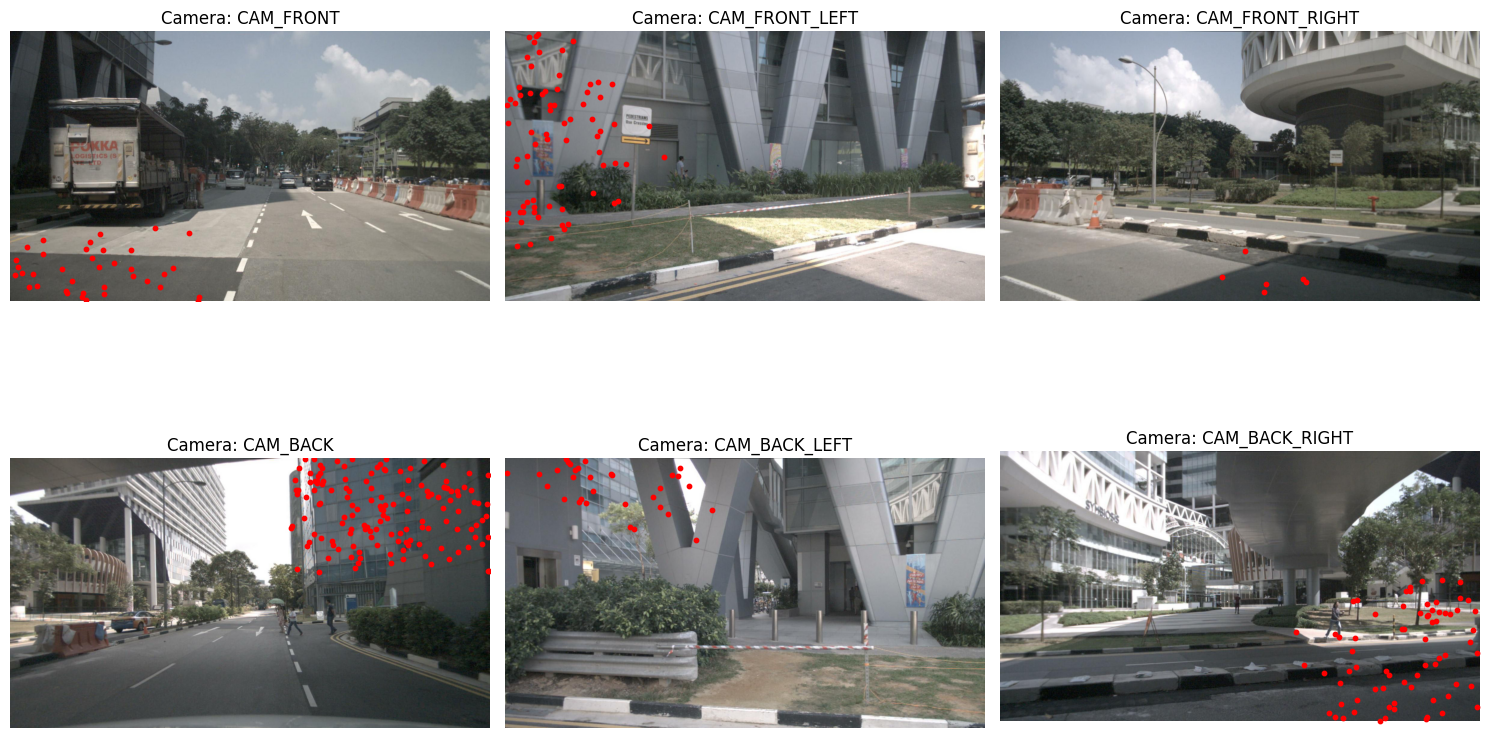

In [8]:
######## WARNING: DONOT CHANGE THE CODE  #######

######## NOTE: PLEASE USE THE CELL OUTPUT TO VERIFY YOUR project_3d_2d ########

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes into a 1D array for easier indexing

for idx, channel in enumerate(camera_channels):
    img_path = img_paths[channel]
    img = Image.open(img_path)
    projected_points = projected_points_all_cameras[channel]
    ax = axes[idx]
    ax.imshow(img) 
    ax.scatter(projected_points[:, 0], projected_points[:, 1], color='red', s=10)
    ax.set_title(f"Camera: {channel}")
    ax.axis('off') 

    
plt.tight_layout()
plt.show()

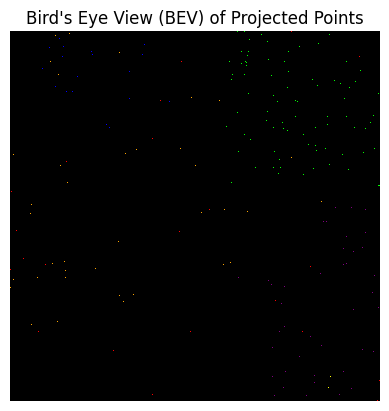

In [9]:
######## NOTE: BONUS TASK  #######
######## NOTE: PLEASE ADD YOUR CODE INSIDE generate_bev   #######

def generate_bev(projected_points_all_cameras, bev_size=(512, 512), point_size=5):
    """
    Generate a BEV grid by plotting projected points from all cameras.
    
    Args:
    - projected_points_all_cameras: Dictionary with camera channels as keys and projected points as values.
    - bev_size: Tuple defining the size of the BEV grid (width, height).
    - point_size: Size of the points to be plotted on the BEV grid.
    
    Returns:
    - BEV image as an array.
    """
    # Initialize BEV image with zeros (RGB channels)
    bev_image = np.zeros((bev_size[1], bev_size[0], 3), dtype=np.uint8)

    # Color mapping for different cameras (adjust as needed)
    color_map = {
        'CAM_FRONT': (255, 0, 0),  # Red
        'CAM_FRONT_LEFT': (255, 165, 0),  # Orange
        'CAM_FRONT_RIGHT': (255, 255, 0),  # Yellow
        'CAM_BACK': (0, 255, 0),   # Green
        'CAM_BACK_LEFT': (0, 0, 255),   # Blue
        'CAM_BACK_RIGHT': (128, 0, 128)  # Purple
    }

    # Minimum and maximum values for BEV coordinates (assuming world coordinates are used for projection)
    min_bev_x = np.inf
    max_bev_x = -np.inf
    min_bev_y = np.inf
    max_bev_y = -np.inf

    # Loop through each camera and its projected points
    for camera_name, points_2d in projected_points_all_cameras.items():
    # Skip points if there are none
        if len(points_2d) == 0:
            continue

        # Extract x and y coordinates from projected points
        points_x = points_2d[:, 0]
        points_y = points_2d[:, 1]

        # Using the extracted x and y coordinates to update the min and max BEV coordinate values
        min_bev_x = min(min_bev_x, np.min(points_x))
        max_bev_x = max(max_bev_x, np.max(points_x))
        min_bev_y = min(min_bev_y, np.min(points_y))
        max_bev_y = max(max_bev_y, np.max(points_y))

        # Convert 3D projected points to 2D BEV coordinates (assuming scaling and offset)
        bev_x = np.round((points_x - min_bev_x) / (max_bev_x - min_bev_x) * (bev_size[0] - 1)).astype(np.int32)
        bev_y = np.round((points_y - min_bev_y) / (max_bev_y - min_bev_y) * (bev_size[1] - 1)).astype(np.int32)

        # Plot points on BEV image with color coding
        color = color_map[camera_name]
        bev_image[bev_y, bev_x, :] = color

    # Normalize BEV image (optional)
    #bev_image = bev_image / np.max(bev_image)

    # Return BEV image or None if no points were within the BEV grid
    #if np.all(bev_image == 0):
        #return None
    #else:
        #return bev_image
    return bev_image
    #return None
    
# Generate BEV
bev_image = generate_bev(projected_points_all_cameras)

# Check if the BEV image is None before plotting
if bev_image is not None:
    plt.imshow(bev_image, cmap='hot', interpolation='nearest')  # Hot colormap for better visibility
    plt.title('Bird\'s Eye View (BEV) of Projected Points')
    plt.axis('off')  # Turn off axis
    plt.show()
else:
    print("No BEV image generated.")
